## Import Required Libraries and Initialize Constants

In [ ]:
import os
import re
import random
import requests
import colorsys
from collections import Counter
import pandas as pd
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from email import policy
from email.parser import BytesParser
from sklearn.metrics import confusion_matrix, classification_report
from pyvis.network import Network
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

IPINFO_TOKEN = "7c7088cbc3a2d1"
DATA_FOLDER  = "data/test"


## Define Helper Functions

In [2]:
def parse_email_headers(path):
    """
    Unified header extractor: works on real .eml (MIME) or plain-text dumps.
    Returns a dict with:
      - file_name
      - return_path
      - message_id
      - received  (list of Received: lines)
      - ips       (unique list of IPv4s seen in Received hops)
    """
    raw = open(path, "rb").read()

    # Attempt full .eml parsing first
    try:
        msg = BytesParser(policy=policy.default).parsebytes(raw)
        return_path  = msg.get("Return-Path", "")
        message_id   = msg.get("Message-ID", "")
        received_hdr = msg.get_all("Received", []) or []
    except Exception:
        # Fallback: manual plain-text parse
        text = None
        try:
            text = raw.decode("utf-8")
        except UnicodeDecodeError:
            text = raw.decode("latin1", errors="ignore")

        # Split off headers (up to first blank line)
        parts = re.split(r"\r?\n\r?\n", text, maxsplit=1)
        header_block = parts[0].splitlines()

        return_path = ""
        message_id  = ""
        received_hdr = []

        current_hdr = None
        for line in header_block:
            # Continuation line?
            if line.startswith((" ", "\t")) and current_hdr == "Received":
                # fold into the last Received entry
                received_hdr[-1] += " " + line.strip()
                continue

            # New header line?
            m = re.match(r"^(Return-Path|Message-ID|Received):\s*(.*)$", line)
            if m:
                hdr_name, hdr_val = m.group(1), m.group(2).strip()
                current_hdr = hdr_name
                if hdr_name == "Return-Path":
                    return_path = hdr_val
                elif hdr_name == "Message-ID":
                    message_id = hdr_val
                elif hdr_name == "Received":
                    received_hdr.append(hdr_val)
            else:
                current_hdr = None

    # Pull IPv4s out of each Received line
    ips = []
    for line in received_hdr:
        ips += re.findall(r"\[?(\d{1,3}(?:\.\d{1,3}){3})\]?", line)
    ips = list(dict.fromkeys(ips))  # dedupe, preserve order

    return {
        "file_name":   os.path.basename(path),
        "return_path": return_path,
        "message_id":  message_id,
        "received":    received_hdr,
        "ips":         ips
    }

def lookup_ipinfo(ip):
    """Call ipinfo.io to get org/country/loc for an IP."""
    if not IPINFO_TOKEN:
        return {"ip": ip}
    url  = f"https://ipinfo.io/{ip}/json?token={IPINFO_TOKEN}"
    data = requests.get(url).json()
    return {
        "ip":      ip,
        "org":     data.get("org", ""),
        "country": data.get("country", ""),
        "loc":     data.get("loc", "")
    }

def build_attack_graph(headers):
    """Build directed graph edges from each hop to the next."""
    G = nx.DiGraph()
    for h in headers:
        for a, b in zip(h["ips"], h["ips"][1:]):
            G.add_edge(a, b)
    return G

# Fix seed for consistent results
DetectorFactory.seed = 0

def detect_language(text):
    try:
        lang = detect(text)
        return lang
    except LangDetectException:
        return "unknown"

# Replace URLs and bare domains with <URL>
def replace_links(text):
    """Substitute all URLs and bare-domain patterns with the placeholder '<URL>'."""
    text = re.sub(r'https?://\S+|www\.\S+', '<URL>', text)
    text = re.sub(
        r'\b[\w\.-]+\.(com|org|net|edu|gov|io|co)(/[^\s]*)?\b',
        '<URL>',
        text
    )
    return text

def extract_email_body(path):
    with open(path, 'rb') as f:
        msg = BytesParser(policy=policy.default).parse(f)

    # Walk through the email parts to find the plain text
    for part in msg.walk():
        content_type = part.get_content_type()
        content_disposition = str(part.get_content_disposition())

        # Skip attachments
        if content_disposition == 'attachment':
            continue

        if content_type == 'text/plain':
            return part.get_content()

    # Fallback if no text/plain found, try to get payload raw
    return msg.get_payload(decode=True).decode(errors='ignore')

def categorize_email(path):
    # Load the whole file as text
    try:
        body = extract_email_body(path)
        body = replace_links(body)
    except Exception:
        # Fallback: read and decode raw
        raw = open(path, 'rb').read()
        try:
            body = raw.decode('utf-8')
            body = replace_links(body)
        except UnicodeDecodeError:
            body = raw.decode('latin1', errors='ignore')
            body = replace_links(body)

    lower = body.lower()

    # Define categories & keywords
    categories = {
        "phishing":  [
            "account", "verify", "password", "urgent", "login", "click",
            "bank", "secure", "alert", "suspend", "transaction", "confirm", "credentials"
        ],
        "promotion": [
            "sale", "discount", "offer", "free", "deal", "subscribe",
            "limited time", "clearance", "coupon", "bargain", "promo", "save", "special"
        ],
        "news":      [
            "update", "today", "news", "breaking", "report", "newsletter",
            "headline", "alert", "bulletin", "press release", "coverage", "journal"
        ],
        "malware":   [
            "attachment", ".exe", ".zip", "download", "run",
            "virus", "trojan", "payload", "malicious", "infected", ".scr", ".bat"
        ],
        "scam":      [
            "lottery", "winner", "prize", "inheritance", "funds", "urgent payment",
            "confidential", "wire transfer", "claim now"
        ],
        "notification": [
            "reminder", "notification", "alert", "system", "service", "maintenance",
            "outage", "downtime", "scheduled"
        ]
    }

    # Score each category
    scores = {cat: sum(lower.count(kw) for kw in kws)
              for cat, kws in categories.items()}
    
    if all(score == 0 for score in scores.values()):
        chosen = "other"
    
    # Pick the top-scoring category if it meets min_hits
    best_cat, best_count = max(scores.items(), key=lambda x: x[1])
    chosen = best_cat
    
    # Detect language
    try:
        language = detect_language(body)
    except LangDetectException:
        language = "unknown"


    return {
        "file_name": os.path.basename(path),
        "category":  chosen,
        "language":  language,
    }


## Parse All Headers and Do IP Lookups

In [3]:
# Read the test‐set ground truth
gt = pd.read_csv(os.path.join(DATA_FOLDER, 'ground_truth.csv'), dtype=str)

# Build a set of the Spam basenames
spam_basenames = set(
    gt.loc[gt['true_label']=='Spam', 'file_name']
)

# Loop only over those files
headers_list = []
ipinfo_list  = []

for fn in sorted(os.listdir(DATA_FOLDER)):
    base, ext = os.path.splitext(fn)
    if base not in spam_basenames:
        continue

    path = os.path.join(DATA_FOLDER, fn)
    h    = parse_email_headers(path)
    headers_list.append(h)
    for ip in h["ips"]:
        ipinfo_list.append(lookup_ipinfo(ip))

df_headers = pd.DataFrame(headers_list)
df_ipinfo = pd.DataFrame(ipinfo_list).drop_duplicates("ip")


## Categorize Email

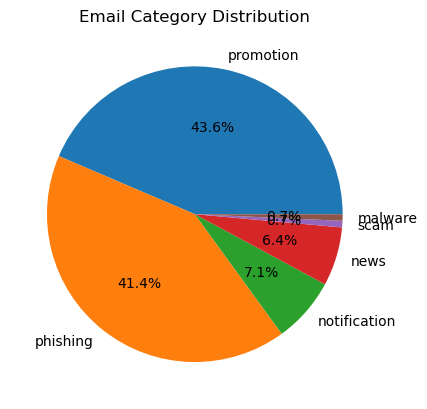

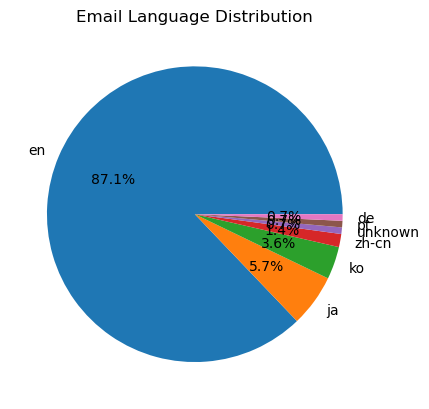

In [4]:
category_records = []
for h in headers_list:
    path = os.path.join(DATA_FOLDER, h["file_name"])
    category_records.append(categorize_email(path))

df_category = pd.DataFrame(category_records)
df_category[["file_name","category"]]

# Count the categories
cat_counts = df_category['category'].value_counts()

# Pie chart for Email Purpose (Category)
plt.figure()
plt.pie(cat_counts, labels=cat_counts.index, autopct='%1.1f%%')
plt.title('Email Category Distribution')

# Language distribution
lang_counts = df_category['language'].value_counts()
plt.figure()
plt.pie(lang_counts, labels=lang_counts.index, autopct='%1.1f%%')
plt.title('Email Language Distribution')

plt.show()

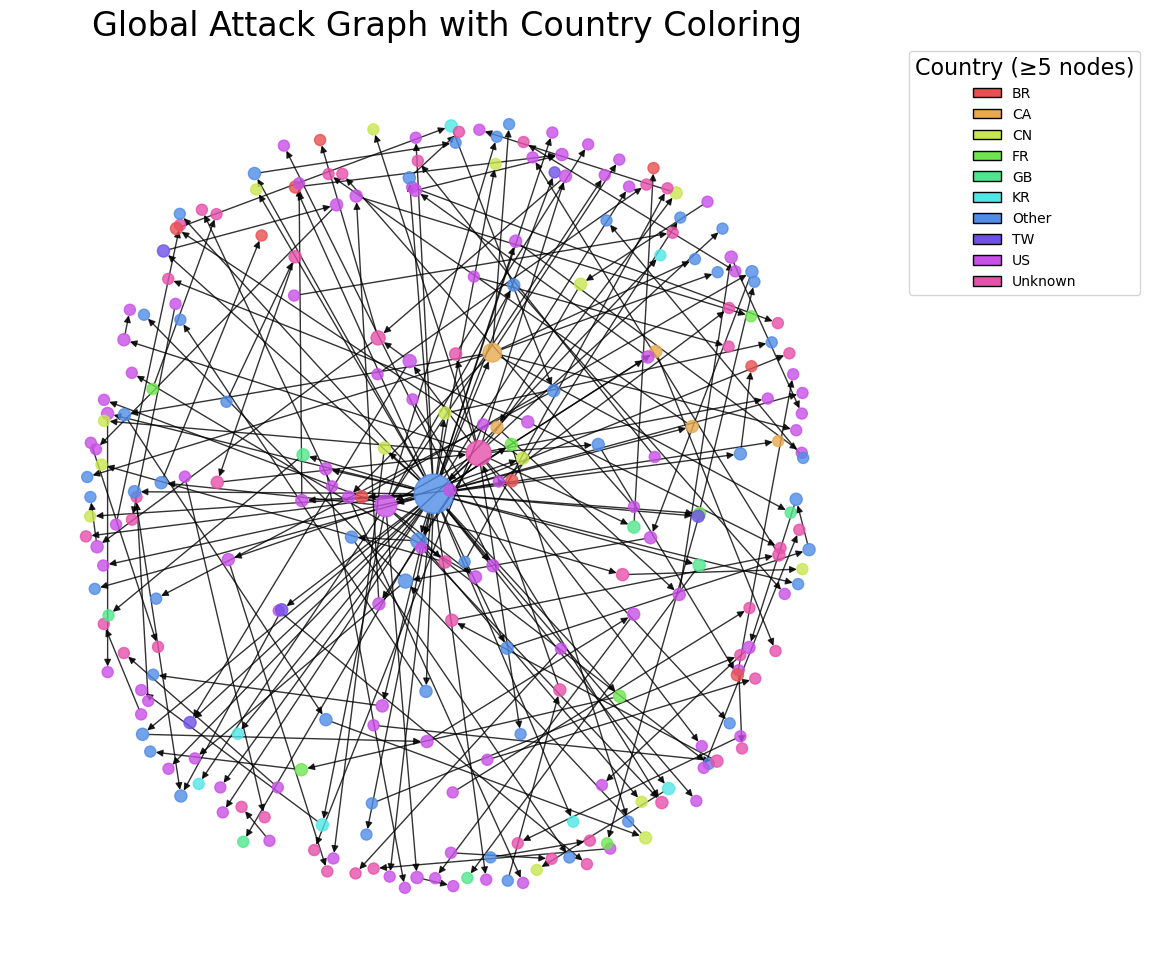

Wrote interactive filtered graph to trace_graph.html


In [5]:
# Build the graph, compute pos and sizes as before
G = build_attack_graph(headers_list)
deg = dict(G.degree())
min_size, max_size = 50, 800
sizes = [min_size + (deg[n]/max(deg.values()))*(max_size-min_size) for n in G.nodes()]
pos = nx.spring_layout(G, k=0.5, seed=42)

# Enrich and extract country_map
all_ips    = {ip for hdr in headers_list for ip in hdr['ips']}
ipinfo     = [lookup_ipinfo(ip) for ip in all_ips]
df_ipinfo  = pd.DataFrame(ipinfo).drop_duplicates(subset=['ip'])
geo_field  = next((c for c in ('country_name','country','region','org')
                   if c in df_ipinfo.columns), None)

if geo_field:
    country_map = df_ipinfo.set_index('ip')[geo_field].to_dict()
else:
    country_map = {ip: 'Unknown' for ip in all_ips}

# Normalize and count occurrences
country_map = {
    ip: (country if country and country.strip() else 'Unknown')
    for ip, country in country_map.items()
}
node_countries = [country_map.get(n, 'Unknown') for n in G.nodes()]
counts = Counter(node_countries)

# Remap low-count countries to “Other”
remapped = {}
for ip, country in country_map.items():
    if counts[country] < 5:
        remapped[ip] = 'Other'
    else:
        remapped[ip] = country
country_map = remapped

# Build the final list of buckets
buckets = set(country_map.values())  # includes Unknown and Other
all_buckets = sorted(buckets)

# Generate distinct colours around the HSV wheel
import colorsys, matplotlib as mpl
n = len(all_buckets)
hsv = [colorsys.hsv_to_rgb(i/n, 0.65, 0.9) for i in range(n)]
cmap = {
    bucket: mpl.colors.to_hex(hsv[i])
    for i, bucket in enumerate(all_buckets)
}

# Assign node colours
colors = [cmap[country_map.get(n, 'Other')] for n in G.nodes()]

# Draw the graph
fig, ax = plt.subplots(figsize=(14,12))
nx.draw(
    G,
    pos=pos,
    node_color=colors,
    node_size=sizes,
    with_labels=False,
    alpha=0.8,
    ax=ax
)
ax.set_title("Global Attack Graph with Country Coloring", fontsize=24)

# Build and place the legend
handles = [
    Patch(facecolor=cmap[b], edgecolor='k', label=b)
    for b in all_buckets
]
ax.legend(
    handles=handles,
    title="Country (≥5 nodes)",
    title_fontsize=16,
    fontsize=10,
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0),
    frameon=True,
    ncol=1
)
fig.subplots_adjust(right=0.75)
plt.show()

# Build IP→categories mapping
ip_categories = {}
for hdr in headers_list:
    cat = df_category.loc[
        df_category['file_name'] == hdr['file_name'],
        'category'
    ].iloc[0]
    for ip in hdr['ips']:
        ip_categories.setdefault(ip, set()).add(cat)

# Build interactive PyVis network with country coloring
net = Network(height='800px', width='100%', directed=True)

# Set options for the PyVis network (leave the shape and size settings intact)
net.set_options("""
{
  "groups": {
    "phishing": { "shape": "dot", "size": 16, "color": "#FF6347" },
    "promotion": { "shape": "dot", "size": 16, "color": "#1E90FF" },
    "news": { "shape": "dot", "size": 16, "color": "#32CD32" },
    "malware": { "shape": "dot", "size": 16, "color": "#8B0000" },
    "scam": { "shape": "dot", "size": 16, "color": "#FFD700" },
    "notification": { "shape": "dot", "size": 16, "color": "#20B2AA" },
    "other": { "shape": "dot", "size": 16, "color": "#A9A9A9" },
    "mixed": { "shape": "dot", "size": 16, "color": "#FF69B4" }
  }
}
""")

# Ensure nodes are added with proper country color
for n in G.nodes():
    country = country_map.get(n, 'Unknown')  # Get country or use 'Unknown'
    categories = ','.join(sorted(ip_categories.get(n, {'other'})))
    organization = df_ipinfo.loc[df_ipinfo['ip'] == n, 'org'].values[0] if not df_ipinfo[df_ipinfo['ip'] == n].empty else 'Unknown'

    if categories not in ["phishing", "promotion", "news", "malware", "scam", "notification", "other"]:
        categories = "mixed"  # Assign mixed category if not in predefined ones
    else:
        categories = categories
    
    # Add node to PyVis network with the correct color
    net.add_node(
        n,
        title=f"{n}\nCountry: {country}\nCategory: {categories}\nOrganization: {organization}",
        group= categories,
    )


# Add edges between nodes
for u, v in G.edges():
    net.add_edge(u, v)

# Write and post-process HTML
html_path = 'trace_graph.html'
net.write_html(html_path, notebook=False)

# Adding filter panel to dynamically filter groups
filter_panel = """
<div id="filter-panel" style="position:absolute;top:10px;left:10px;
     background:white;padding:8px;border:1px solid #ccc;z-index:999;">
  <label><input type="checkbox" checked onclick="toggleGroup('phishing')"> Phishing</label><br>
  <label><input type="checkbox" checked onclick="toggleGroup('promotion')"> Promotion</label><br>
  <label><input type="checkbox" checked onclick="toggleGroup('news')"> News</label><br>
  <label><input type="checkbox" checked onclick="toggleGroup('malware')"> Malware</label><br>
  <label><input type="checkbox" checked onclick="toggleGroup('scam')"> Scam</label><br>
  <label><input type="checkbox" checked onclick="toggleGroup('notification')"> Notification</label><br>
  <label><input type="checkbox" checked onclick="toggleGroup('other')"> Other</label><br>
<label><input type="checkbox" checked onclick="toggleGroup('mixed')"> Mixed</label><br>
</div>
<script type="text/javascript">
  function toggleGroup(groupName) {
    const nodes = network.body.data.nodes.get({
      filter: node => node.group === groupName
    });
    const visible = document.querySelector(
      "input[onclick=\\"toggleGroup('" + groupName + "')\\"]"
    ).checked;
    nodes.forEach(n => {
      network.body.data.nodes.update({ id: n.id, hidden: !visible });
    });
  }
</script>
</body>
"""

# Append filter panel and save HTML
with open(html_path, 'r', encoding='utf-8') as f:
    content = f.read()
content = content.replace('</body>', filter_panel)
with open(html_path, 'w', encoding='utf-8') as f:
    f.write(content)

print(f"Wrote interactive filtered graph to {html_path}")


In [6]:
# Cell 6: Save CSV outputs (optional)

df_headers.to_csv("email_headers.csv", index=False)
df_ipinfo.to_csv("ipinfo_data.csv", index=False)
df_category.to_csv("email_category.csv", index=False)


## False Negative Tracing

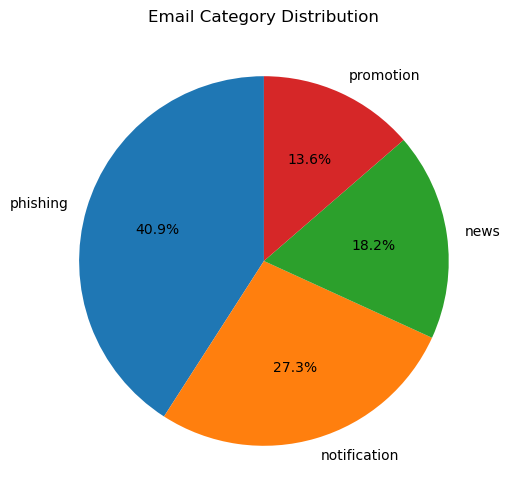

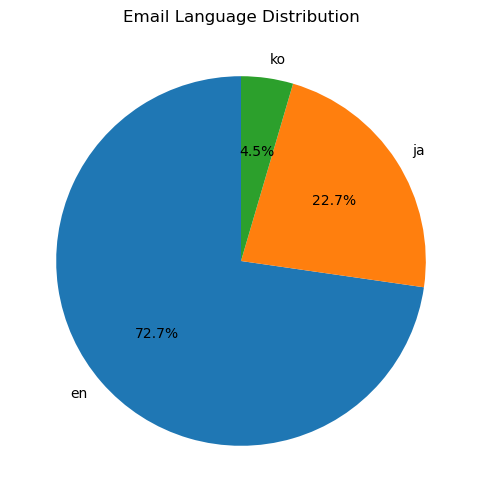

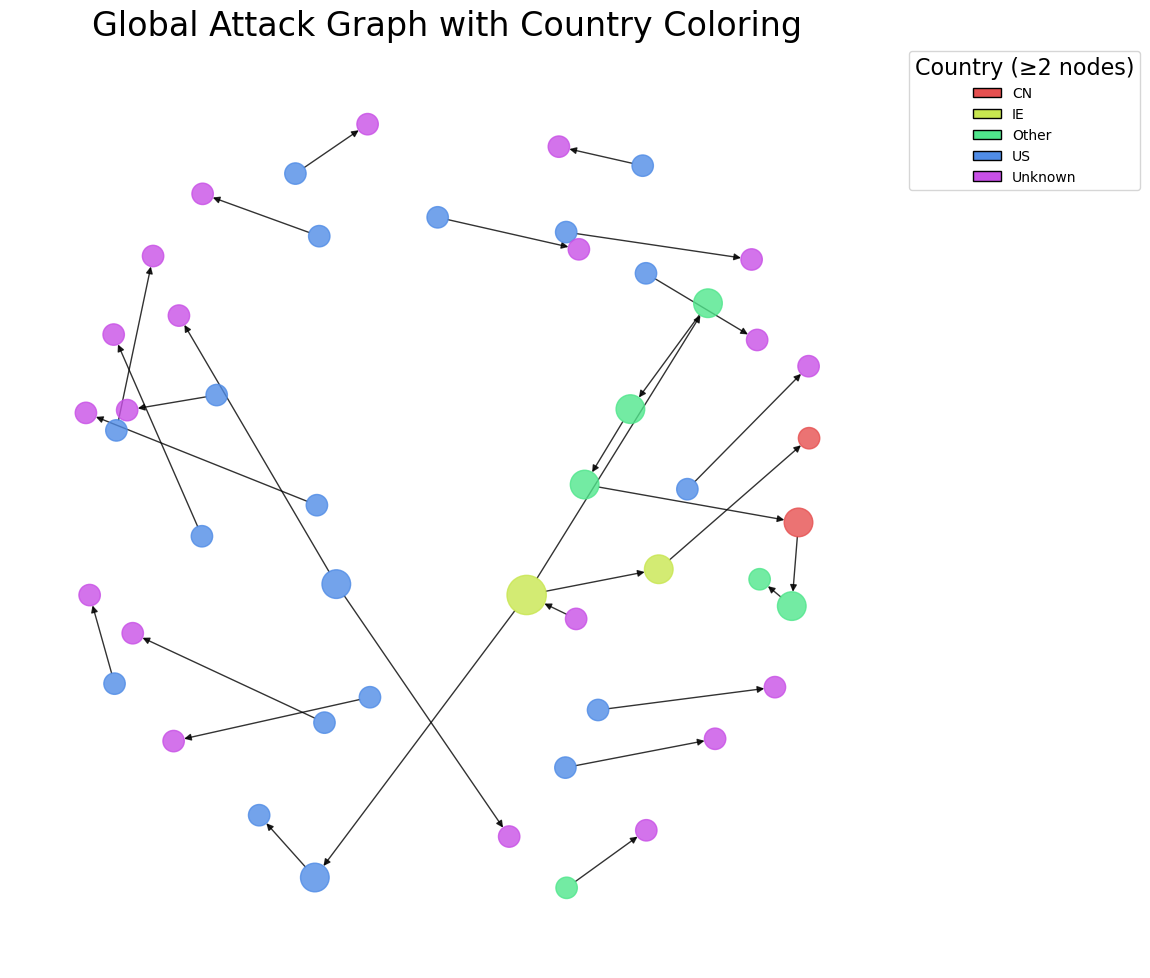

Wrote interactive filtered graph to false_negative_graph.html


In [ ]:
# Spam list (basenames only)
my_spam_list = [
    "Spam21.f32dcf9a564da7e27f9fcad664cb0fe1",
    "Spam56.8d996c0bc08a47a90611de2e8a829048",
    "Spam62.794d3043053407d8e0c075a9a71902bd",
    "Spam102.eml",
    "Spam105.eml",
    "Spam107.eml",
    "Spam108.eml",
    "Spam109.eml",
    "Spam110.eml",
    "Spam111.eml",
    "Spam112.eml",
    "Spam114.eml",
    "Spam115.eml",
    "Spam116.eml",
    "Spam119.eml",
    "Spam123.eml",
    "Spam124.eml",
    "Spam125.eml",
    "Spam126.eml",
    "Spam127.eml",
    "Spam128.eml",
    "Spam134.eml",
]

# Normalize my_spam_list: remove extensions if needed for matching
my_spam_basenames = set(os.path.splitext(f)[0] for f in my_spam_list)

# Parse headers and collect IP info only for files in my_spam_list
headers_list = []
ipinfo_list = []

for fn in sorted(os.listdir(DATA_FOLDER)):
    base, ext = os.path.splitext(fn)
    if base not in my_spam_basenames:
        continue

    path = os.path.join(DATA_FOLDER, fn)
    h = parse_email_headers(path)
    headers_list.append(h)
    for ip in h["ips"]:
        ipinfo_list.append(lookup_ipinfo(ip))

df_headers = pd.DataFrame(headers_list)
df_ipinfo = pd.DataFrame(ipinfo_list).drop_duplicates("ip")

# Categorize emails only for those in headers_list
category_records = []
for h in headers_list:
    path = os.path.join(DATA_FOLDER, h["file_name"])
    category_records.append(categorize_email(path))

df_category = pd.DataFrame(category_records)

# Plot pie charts for category and language
cat_counts = df_category['category'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(cat_counts, labels=cat_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Email Category Distribution')
plt.show()

lang_counts = df_category['language'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(lang_counts, labels=lang_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Email Language Distribution')
plt.show()

# Build the graph, compute pos and sizes as before
G = build_attack_graph(headers_list)
deg = dict(G.degree())
min_size, max_size = 50, 800
sizes = [min_size + (deg[n]/max(deg.values()))*(max_size-min_size) for n in G.nodes()]
pos = nx.spring_layout(G, k=0.5, seed=42)

# Enrich and extract country_map
all_ips    = {ip for hdr in headers_list for ip in hdr['ips']}
ipinfo     = [lookup_ipinfo(ip) for ip in all_ips]
df_ipinfo  = pd.DataFrame(ipinfo).drop_duplicates(subset=['ip'])
geo_field  = next((c for c in ('country_name','country','region','org')
                   if c in df_ipinfo.columns), None)

if geo_field:
    country_map = df_ipinfo.set_index('ip')[geo_field].to_dict()
else:
    country_map = {ip: 'Unknown' for ip in all_ips}

# Normalize and count occurrences
country_map = {
    ip: (country if country and country.strip() else 'Unknown')
    for ip, country in country_map.items()
}
node_countries = [country_map.get(n, 'Unknown') for n in G.nodes()]
counts = Counter(node_countries)

# Remap low-count countries to “Other”
remapped = {}
for ip, country in country_map.items():
    if counts[country] < 2:
        remapped[ip] = 'Other'
    else:
        remapped[ip] = country
country_map = remapped

# Build the final list of buckets
buckets = set(country_map.values())  # includes Unknown and Other
all_buckets = sorted(buckets)

# Generate distinct colours around the HSV wheel
n = len(all_buckets)
hsv = [colorsys.hsv_to_rgb(i/n, 0.65, 0.9) for i in range(n)]
cmap = {
    bucket: mpl.colors.to_hex(hsv[i])
    for i, bucket in enumerate(all_buckets)
}

# Assign node colours
colors = [cmap[country_map.get(n, 'Other')] for n in G.nodes()]

# Draw the graph
fig, ax = plt.subplots(figsize=(14,12))
nx.draw(
    G,
    pos=pos,
    node_color=colors,
    node_size=sizes,
    with_labels=False,
    alpha=0.8,
    ax=ax
)
ax.set_title("Global Attack Graph with Country Coloring", fontsize=24)

# Build and place the legend
handles = [
    Patch(facecolor=cmap[b], edgecolor='k', label=b)
    for b in all_buckets
]
ax.legend(
    handles=handles,
    title="Country (≥2 nodes)",
    title_fontsize=16,
    fontsize=10,
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0),
    frameon=True,
    ncol=1
)
fig.subplots_adjust(right=0.75)
plt.show()

# Build IP→categories mapping
ip_categories = {}
for hdr in headers_list:
    cat = df_category.loc[
        df_category['file_name'] == hdr['file_name'],
        'category'
    ].iloc[0]
    for ip in hdr['ips']:
        ip_categories.setdefault(ip, set()).add(cat)

# Build interactive PyVis network with country coloring
net = Network(height='800px', width='100%', directed=True)

# Set options for the PyVis network (leave the shape and size settings intact)
net.set_options("""
{
  "groups": {
    "phishing": { "shape": "dot", "size": 16, "color": "#FF6347" },
    "promotion": { "shape": "dot", "size": 16, "color": "#1E90FF" },
    "news": { "shape": "dot", "size": 16, "color": "#32CD32" },
    "malware": { "shape": "dot", "size": 16, "color": "#8B0000" },
    "scam": { "shape": "dot", "size": 16, "color": "#FFD700" },
    "notification": { "shape": "dot", "size": 16, "color": "#20B2AA" },
    "other": { "shape": "dot", "size": 16, "color": "#A9A9A9" },
    "mixed": { "shape": "dot", "size": 16, "color": "#FF69B4" }
  }
}
""")

# Ensure nodes are added with proper country color
for n in G.nodes():
    country = country_map.get(n, 'Unknown')  # Get country or use 'Unknown'
    categories = ','.join(sorted(ip_categories.get(n, {'other'})))
    organization = df_ipinfo.loc[df_ipinfo['ip'] == n, 'org'].values[0] if not df_ipinfo[df_ipinfo['ip'] == n].empty else 'Unknown'

    if categories not in ["phishing", "promotion", "news", "malware", "scam", "notification", "other"]:
        categories = "mixed"  # Assign mixed category if not in predefined ones
    else:
        categories = categories
    
    # Add node to PyVis network with the correct color
    net.add_node(
        n,
        title=f"{n}\nCountry: {country}\nCategory: {categories}\nOrganization: {organization}",
        group= categories,
    )


# Add edges between nodes
for u, v in G.edges():
    net.add_edge(u, v)

# Write and post-process HTML
html_path = 'false_negative_graph.html'
net.write_html(html_path, notebook=False)

# Adding filter panel to dynamically filter groups
filter_panel = """
<div id="filter-panel" style="position:absolute;top:10px;left:10px;
     background:white;padding:8px;border:1px solid #ccc;z-index:999;">
  <label><input type="checkbox" checked onclick="toggleGroup('phishing')"> Phishing</label><br>
  <label><input type="checkbox" checked onclick="toggleGroup('promotion')"> Promotion</label><br>
  <label><input type="checkbox" checked onclick="toggleGroup('news')"> News</label><br>
  <label><input type="checkbox" checked onclick="toggleGroup('malware')"> Malware</label><br>
  <label><input type="checkbox" checked onclick="toggleGroup('scam')"> Scam</label><br>
  <label><input type="checkbox" checked onclick="toggleGroup('notification')"> Notification</label><br>
  <label><input type="checkbox" checked onclick="toggleGroup('other')"> Other</label><br>
<label><input type="checkbox" checked onclick="toggleGroup('mixed')"> Mixed</label><br>
</div>
<script type="text/javascript">
  function toggleGroup(groupName) {
    const nodes = network.body.data.nodes.get({
      filter: node => node.group === groupName
    });
    const visible = document.querySelector(
      "input[onclick=\\"toggleGroup('" + groupName + "')\\"]"
    ).checked;
    nodes.forEach(n => {
      network.body.data.nodes.update({ id: n.id, hidden: !visible });
    });
  }
</script>
</body>
"""

# Append filter panel and save HTML
with open(html_path, 'r', encoding='utf-8') as f:
    content = f.read()
content = content.replace('</body>', filter_panel)
with open(html_path, 'w', encoding='utf-8') as f:
    f.write(content)

print(f"Wrote interactive filtered graph to {html_path}")